In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches

from matplotlib.dates import DateFormatter

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from unittest.mock import inplace
from IPython.display import set_matplotlib_formats
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, KFold
from random import randint

from scipy.io import loadmat
import seaborn as sns
import glob
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import datetime
import math
import time
import datetime
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
warnings.filterwarnings(action='ignore')
#그래프에서 음수 값이 나올 때, 깨지는 현상 방지
mpl.rc('axes',unicode_minus=False)

# Korean Font Setting
plt.rcParams["font.family"] = 'Malgun Gothic'

In [2]:
def load_data(battery):
  mat = loadmat(battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
display(dataset)
dataset.describe() 

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


cycle  ambient_temperature            datetime  capacity  \
0          1                   24 2008-04-02 15:25:41  1.856487   
1          1                   24 2008-04-02 15:25:41  1.856487   
2          1                   24 2008-04-02 15:25:41  1.856487   
3          1                   24 2008-04-02 15:25:41  1.856487   
4          1                   24 2008-04-02 15:25:41  1.856487   
...      ...                  ...                 ...       ...   
50280    168                   24 2008-05-27 20:45:42  1.325079   
50281    168                   24 2008-05-27 20:45:42  1.325079   
50282    168                   24 2008-05-27 20:45:42  1.325079   
50283    168                   24 2008-05-27 20:45:42  1.325079   
50284    168                   24 2008-05-27 20:45:42  1.325079   

       voltage_measured  current_measured  temperature_measured  current_load  \
0              4.191492         -0.004902             24.330034       -0.0006   
1              4.190749         -0.001478             24.325993       -0.0006   
2              3.974871         -2.012528             24.389085       -1.9982   
3              3.951717         -2.013979             24.544752       -1.9982   
4              3.934352         -2.011144             24.731385       -1.9982   
...                 ...               ...                   ...           ...   
50280          3.579262         -0.001569             34.864823        0.0006   
50281          3.581964         -0.003067             34.814770        0.0006   
50282          3.584484         -0.003079             34.676258        0.0006   
50283          3.587336          0.001219             34.565580        0.0006   
50284          3.589937         -0.000583             34.405920        0.0006   

       voltage_load      time  
0             0.000     0.000  
1             4.206    16.781  
2             3.062    35.703  
3             3.030    53.781  
4             3.011    71.922  
...             ...       ...  
50280         0.000  2781.312  
50281         0.000  2791.062  
50282         0.000  2800.828  
50283         0.000  2810.640  
50284         0.000  2820.390  

[50285 rows x 10 columns]

cycle  ambient_temperature      capacity  voltage_measured  \
count  50285.000000              50285.0  50285.000000      50285.000000   
mean      88.125942                 24.0      1.560345          3.515268   
std       45.699687                  0.0      0.182380          0.231778   
min        1.000000                 24.0      1.287453          2.455679   
25%       50.000000                 24.0      1.386229          3.399384   
50%       88.000000                 24.0      1.538237          3.511664   
75%      127.000000                 24.0      1.746871          3.660903   
max      168.000000                 24.0      1.856487          4.222920   

       current_measured  temperature_measured  current_load  voltage_load  \
count      50285.000000          50285.000000  50285.000000  50285.000000   
mean          -1.806032             32.816991      1.362700      2.308406   
std            0.610502              3.987515      1.313698      0.800300   
min           -2.029098             23.214802     -1.998400      0.000000   
25%           -2.013415             30.019392      1.998000      2.388000   
50%           -2.012312             32.828944      1.998200      2.533000   
75%           -2.011052             35.920887      1.998200      2.690000   
max            0.007496             41.450232      1.998400      4.238000   

               time  
count  50285.000000  
mean    1546.208924  
std      906.640295  
min        0.000000  
25%      768.563000  
50%     1537.031000  
75%     2305.984000  
max     3690.234000

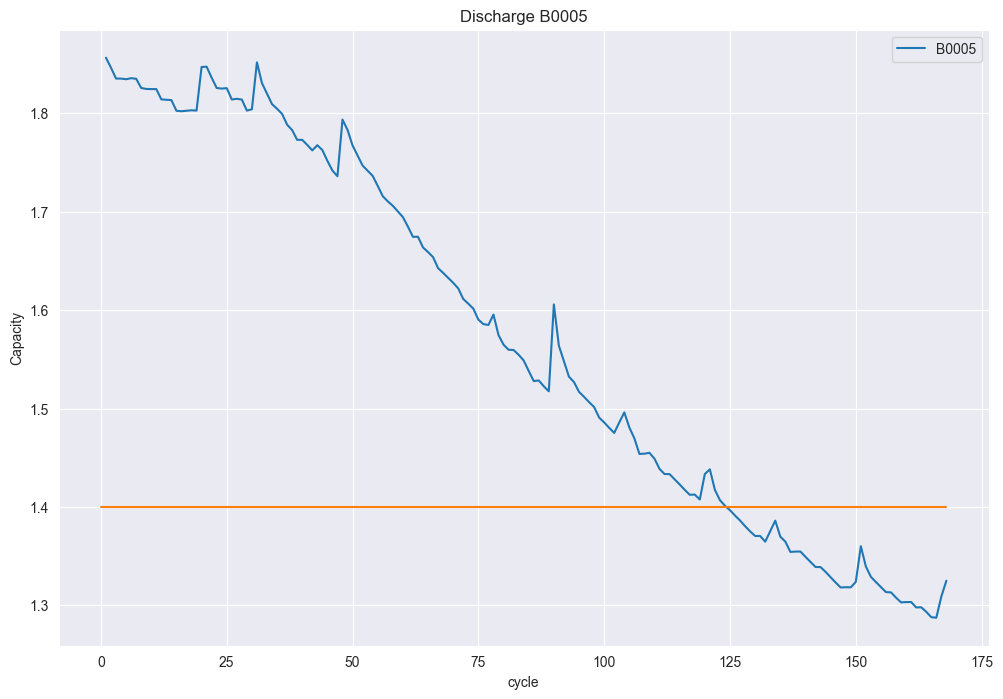

In [3]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'], label='B0005')
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')
plt.legend(loc='best')

In [4]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Text(0.5, 1.0, 'Discharge B0005')

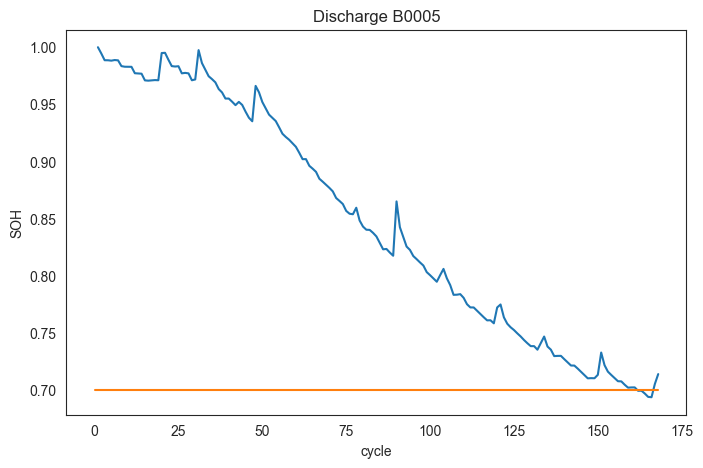

In [5]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [6]:
C = dataset['capacity'][0]
train_test_dict = {}
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity','datetime', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]

train_dataset = train_dataset.groupby(['datetime']).mean().reset_index(drop=False)
soh = soh.drop_duplicates(['SoH']).reset_index(drop=True)
train_dataset['SoH'] = soh['SoH']
train_dataset = train_dataset[['datetime', 'SoH']]

display(train_dataset)


datetime       SoH
0   2008-04-02 15:25:41  1.000000
1   2008-04-02 19:43:48  0.994527
2   2008-04-03 00:01:06  0.988614
3   2008-04-03 04:16:37  0.988567
4   2008-04-03 08:33:25  0.988235
..                  ...       ...
163 2008-05-26 10:44:38  0.696726
164 2008-05-26 15:30:43  0.693785
165 2008-05-26 20:21:04  0.693488
166 2008-05-27 15:52:41  0.705103
167 2008-05-27 20:45:42  0.713756

[168 rows x 2 columns]

In [7]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
import numpy as np
from torch.utils import data


class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual 
        
class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size).type(torch.float64))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]).type(torch.float64))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size).type(torch.float64))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]).type(torch.float64))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size).type(torch.float64)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]).type(torch.float64))

            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size).type(torch.float64)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]).type(torch.float64))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)

        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])                
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)

        x = seasonal_output + trend_output

        return x.permute(0,2,1)


In [8]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - (seq_length)):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, -1]
        date_ = time_series
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

class Data(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
        

In [9]:
targets = 'SoH'
date = 'datetime'

train_size = int(len(train_dataset)* 0.7)
train_df = train_dataset[:train_size]
train_v, train_date = train_df[[targets]], train_df[[date]]

test_df = train_dataset[train_size:]
test_v, test_date = test_df[[targets]], test_df[date]

sc = StandardScaler()
sc = sc.fit(train_v)
train_x = sc.transform(train_v)
test_x = sc.transform(test_v)


In [10]:
seq_length= 3

normed_trainX, normed_trainY  = build_dataset(train_x, seq_length)
normed_testX, normed_testY = build_dataset(test_x, seq_length)

In [11]:
normed_testX.shape

(48, 3, 1)

In [12]:
train_ds = Data(normed_trainX, normed_trainY)
test_ds = Data(normed_testX, normed_testY)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 1, shuffle=False)
test_dl  = torch.utils.data.DataLoader(test_ds,  batch_size = 1, shuffle=False)

In [13]:

### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 50
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=seq_length,
                            forcast_size=1,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in range(1, epoch+1):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if test_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = test_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(test_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f},  test_loss : {:.3f}".format(epoch, np.mean(loss_list), test_loss))

valid_loss=0.025, test_los0.025, Model Save
epoch = 1, train_loss : 0.226,  test_loss : 0.025
valid_loss=0.003, test_los0.003, Model Save
epoch = 2, train_loss : 0.079,  test_loss : 0.003
epoch = 3, train_loss : 0.029,  test_loss : 0.029
epoch = 4, train_loss : 0.014,  test_loss : 0.050
epoch = 5, train_loss : 0.011,  test_loss : 0.059
epoch = 6, train_loss : 0.011,  test_loss : 0.062
epoch = 7, train_loss : 0.011,  test_loss : 0.061
epoch = 8, train_loss : 0.011,  test_loss : 0.059
epoch = 9, train_loss : 0.010,  test_loss : 0.057
epoch = 10, train_loss : 0.010,  test_loss : 0.055
epoch = 11, train_loss : 0.010,  test_loss : 0.054
epoch = 12, train_loss : 0.010,  test_loss : 0.052
epoch = 13, train_loss : 0.010,  test_loss : 0.050
epoch = 14, train_loss : 0.010,  test_loss : 0.048
epoch = 15, train_loss : 0.010,  test_loss : 0.047
epoch = 16, train_loss : 0.010,  test_loss : 0.046
epoch = 17, train_loss : 0.010,  test_loss : 0.044
epoch = 18, train_loss : 0.010,  test_loss : 0.043
epo

In [14]:
DLinear_model.eval()
y_list , pred_y_list = [], []

with torch.no_grad():
    for data, target in test_dl:
        output = DLinear_model(data)
        y = target.numpy()
        pred_y = output.numpy().reshape(-1)
        pred_y_list.append(pred_y)
        y_list.append(y)



In [15]:
mean_squared_error(y_list, pred_y_list)

0.0048962334070060155

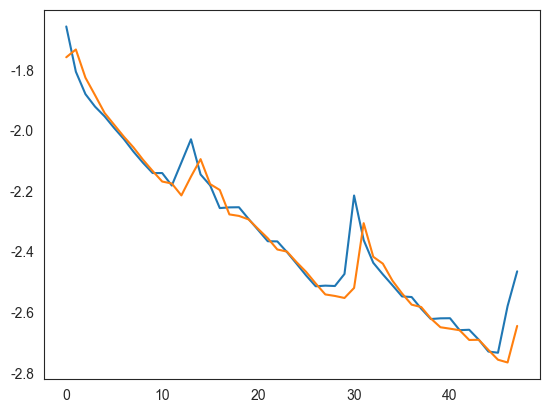

In [16]:
plt.plot(y_list)
plt.plot(pred_y_list)

In [19]:
real_test, capacity_test = load_data('B0006')

C = real_test['capacity'][0]

soh = []
for i in range(len(real_test)):
  soh.append([real_test['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

soh = soh.drop_duplicates(['SoH']).reset_index(drop=True)

print(soh.shape)
real_test_val = sc.transform(soh)
real_test_x, real_test_y  = build_dataset(real_test_val, seq_length)
print(real_test_x.shape, real_test_y.shape)
real_test_ds = Data(real_test_x, real_test_y)
real_test_dl  = torch.utils.data.DataLoader(real_test_ds,  batch_size = 1, shuffle=False)
DLinear_model.eval()
y_list , pred_y_list = [], []

with torch.no_grad():
    for data, target in real_test_dl:
        output = DLinear_model(data)
        y = target.numpy()
        pred_y = output.numpy().reshape(-1)
        pred_y_list.append(pred_y)
        y_list.append(y)

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
(168, 1)
(165, 3, 1) (165,)


Text(0.5, 1.0, 'B0006')

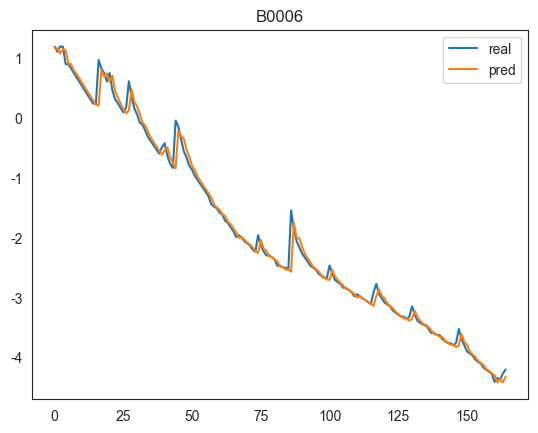

In [167]:
plt.plot(y_list, label='real')
plt.plot(pred_y_list, label='pred')
plt.legend(loc='best')
plt.title('B0006')

In [20]:
real_test, capacity_test = load_data('B0007')
C = real_test['capacity'][0]

soh = []
for i in range(len(real_test)):
  soh.append([real_test['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

soh = soh.drop_duplicates(['SoH']).reset_index(drop=True)

real_test_val = sc.transform(soh)

real_test_x, real_test_y  = build_dataset(real_test_val, seq_length)


real_test_ds = Data(real_test_x, real_test_y)
real_test_dl  = torch.utils.data.DataLoader(real_test_ds,  batch_size = 1, shuffle=False)
DLinear_model.eval()
y_list , pred_y_list = [], []

with torch.no_grad():
    for data, target in real_test_dl:
        output = DLinear_model(data)
        y = target.numpy()
        pred_y = output.numpy().reshape(-1)
        pred_y_list.append(pred_y)
        y_list.append(y)

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]


Text(0.5, 1.0, 'B0007')

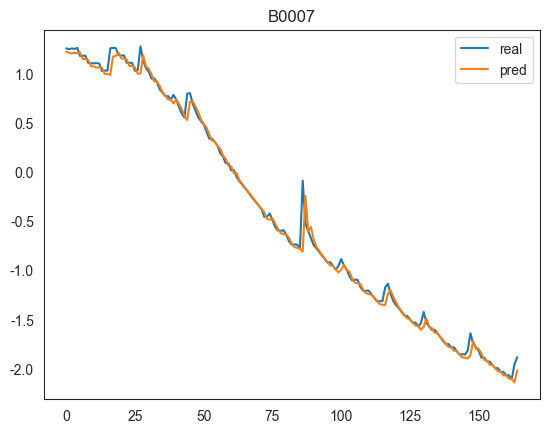

In [21]:
plt.plot(y_list, label='real')
plt.plot(pred_y_list, label='pred')
plt.legend(loc='best')
plt.title('B0007')